# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [17]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


# 1. Load Dataset

In [18]:
df = pd.read_csv('./data/final_0509.csv')
# 한국 일일확진자 변수 제거
df.drop(['Unnamed: 0'], axis=1, inplace=True)

## lag 변수 생성

In [19]:
df.Date = pd.to_datetime(df.Date)
#df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [20]:
lag_col= list(df.columns)

In [21]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)

In [22]:
df.tail()

,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,GB_conf,...,news_lag3,covid_tr_lag1,covid_tr_lag2,covid_tr_lag3,coro_tr_lag1,coro_tr_lag2,coro_tr_lag3,target_lag1,target_lag2,target_lag3
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,0,0,476,284,7933,6,0,34037,557,6204,...,1763.0,43.0,63.0,59.0,18.0,18.0,18.0,4.0,5.0,12.0
2020-05-02,0,0,445,156,9623,13,3,29078,561,4815,...,1117.0,48.0,43.0,63.0,18.0,18.0,18.0,8.0,4.0,5.0
2020-05-03,4,0,335,295,10633,8,4,25501,564,4342,...,1266.0,43.0,48.0,43.0,18.0,18.0,18.0,8.0,8.0,4.0
2020-05-04,6,0,199,262,10581,3,2,22335,567,3990,...,1104.0,55.0,43.0,48.0,18.0,18.0,18.0,10.0,8.0,8.0
2020-05-05,0,0,318,199,10102,2,0,23976,462,4411,...,732.0,30.0,55.0,43.0,17.0,18.0,18.0,8.0,10.0,8.0


# Data Exploration

In [23]:
# 결측치 확인
df.isnull().sum().sum()

0

In [24]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['target'].shape))

전체 데이터 shape: (102, 332)
target feature shape: (102,)


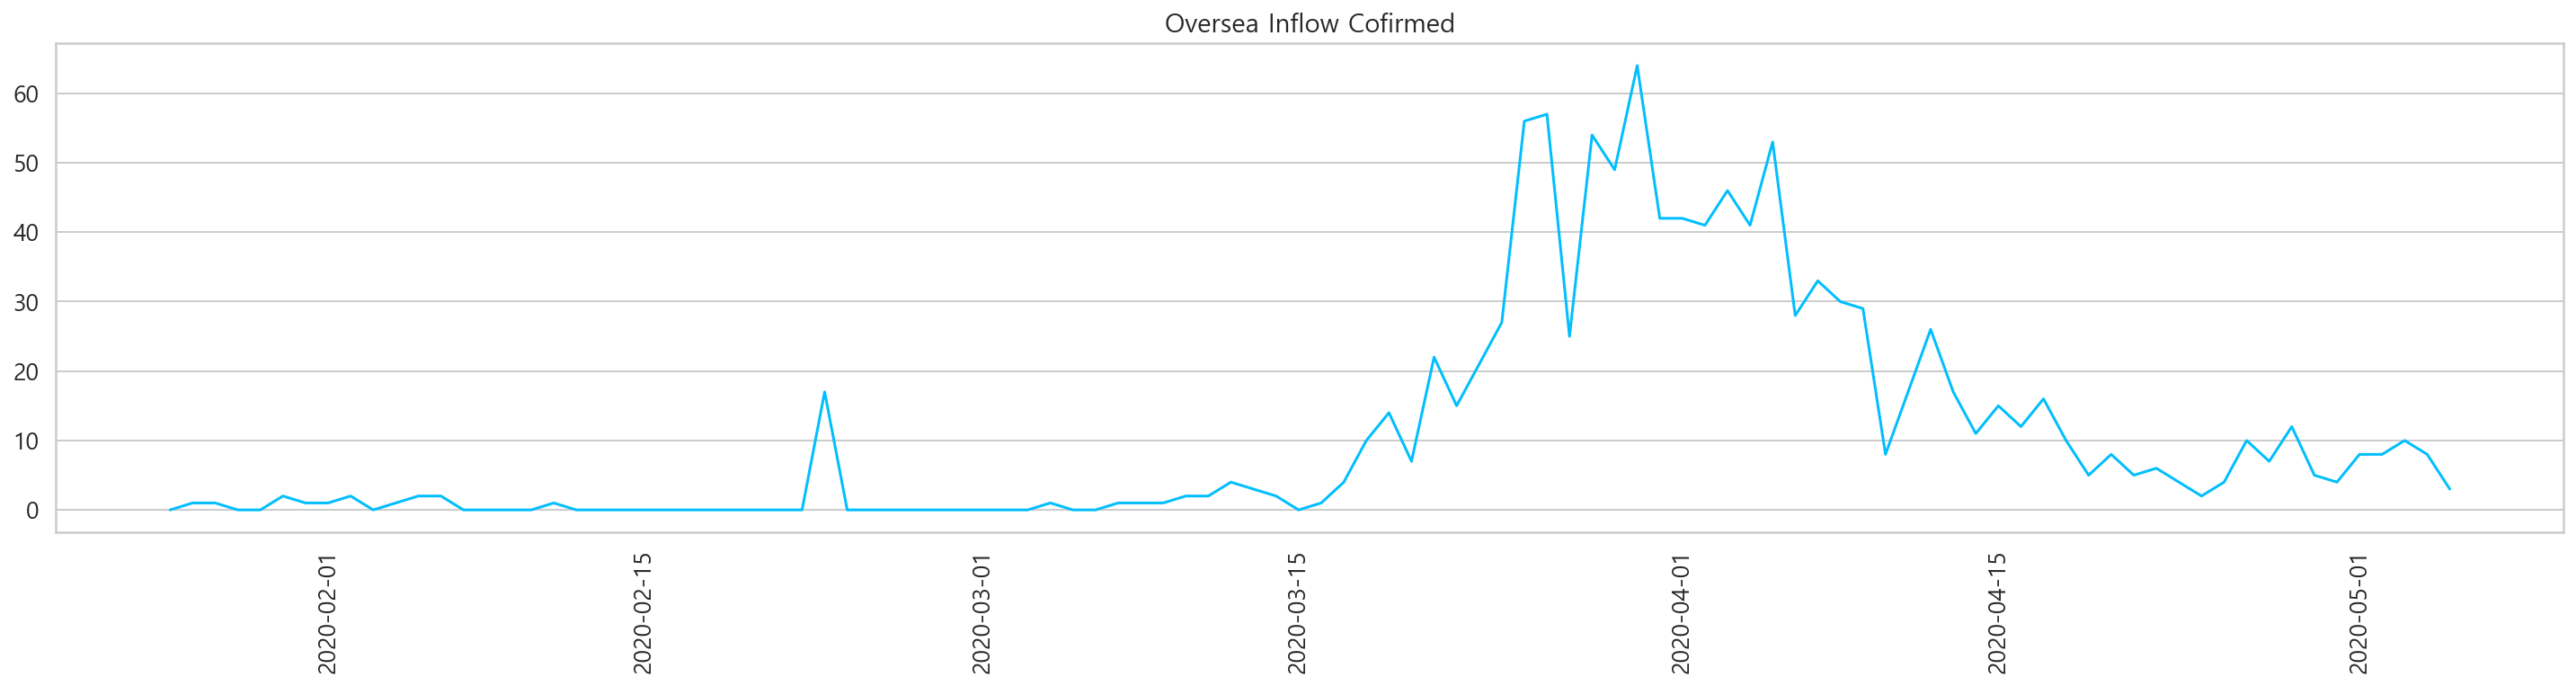

In [25]:
plt.figure(figsize=(25,5))
plt.plot(df['target'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# LSTM Model

In [26]:
X_cols = list(df.columns)
X_cols.remove('target')

In [27]:
# 테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']

In [28]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [29]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (88, 331)
test set :  (14, 331)


In [30]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [31]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [32]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [33]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([88, 1, 331])
X_test : torch.Size([14, 1, 331])
y_train : torch.Size([88, 1])
y_test : torch.Size([14, 1])


# Building a Model

In [34]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [35]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [36]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=200

In [37]:
# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.1514 test loss: 0.044
Epoch 10 train loss: 0.1334 test loss: 0.0325
Epoch 20 train loss: 0.1163 test loss: 0.023
Epoch 30 train loss: 0.0993 test loss: 0.014
Epoch 40 train loss: 0.0813 test loss: 0.0059
Epoch 50 train loss: 0.062 test loss: 0.0023
Epoch 60 train loss: 0.0418 test loss: 0.0111
Epoch 70 train loss: 0.0266 test loss: 0.0395
Epoch 80 train loss: 0.0197 test loss: 0.0453
Epoch 90 train loss: 0.0146 test loss: 0.0228
Epoch 100 train loss: 0.0104 test loss: 0.0124
Epoch 110 train loss: 0.0079 test loss: 0.0059
Epoch 120 train loss: 0.0072 test loss: 0.0034
Epoch 130 train loss: 0.0071 test loss: 0.0027
Epoch 140 train loss: 0.0071 test loss: 0.0026
Epoch 150 train loss: 0.007 test loss: 0.0027
Epoch 160 train loss: 0.007 test loss: 0.0027
Epoch 170 train loss: 0.0069 test loss: 0.0027
Epoch 180 train loss: 0.0069 test loss: 0.0026
Epoch 190 train loss: 0.0069 test loss: 0.0026


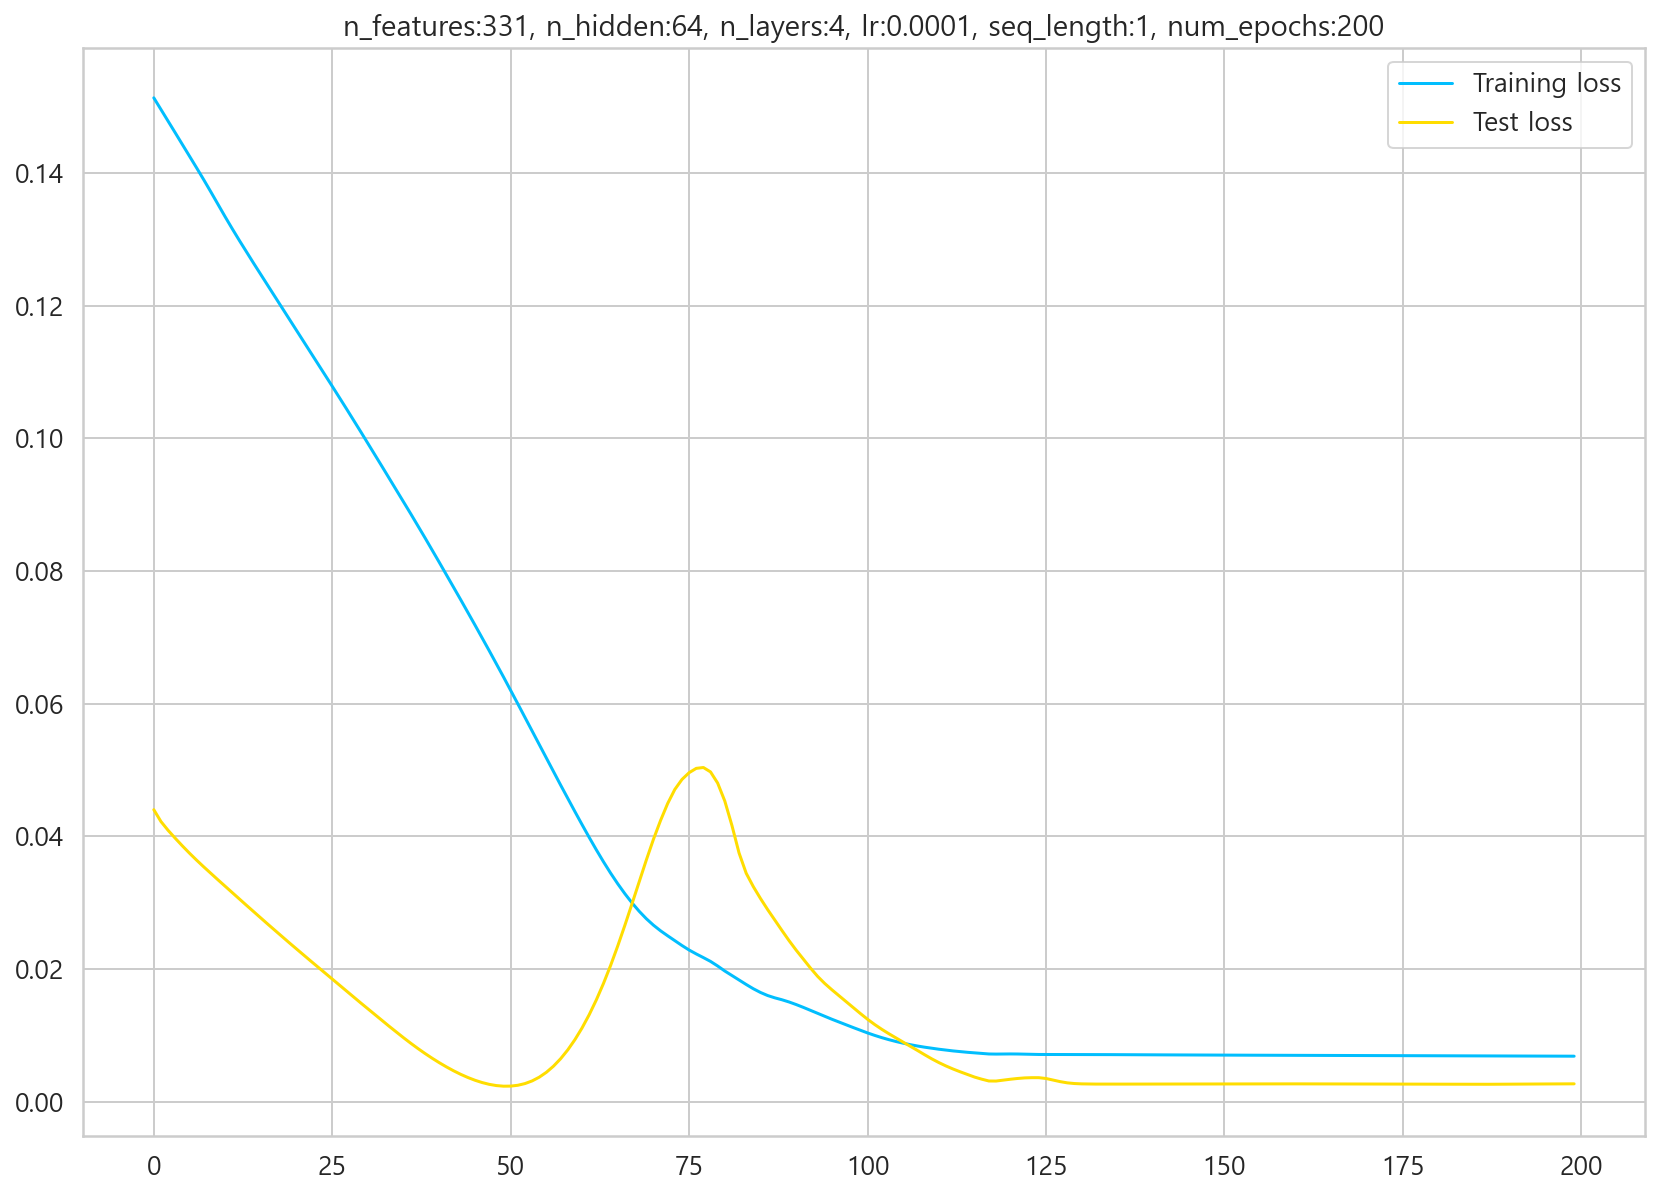

In [38]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

# Predicting daily cases

In [39]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [40]:
preds

[0.06998497992753983,
 0.06948540359735489,
 0.07062841206789017,
 0.0723128542304039,
 0.07295800000429153,
 0.0731896236538887,
 0.07180165499448776,
 0.06876667588949203,
 0.06649280339479446,
 0.06556165963411331,
 0.06388022750616074,
 0.06263292580842972,
 0.0621790811419487,
 0.06176876276731491]

In [41]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [42]:
pred_values

array([[4.47903872],
       [4.44706583],
       [4.52021837],
       [4.62802267],
       [4.669312  ],
       [4.68413591],
       [4.59530592],
       [4.40106726],
       [4.25553942],
       [4.19594622],
       [4.08833456],
       [4.00850725],
       [3.97946119],
       [3.95320082]])

In [43]:
pred_values_ceiled  = list(pred_values.flatten())

In [44]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [45]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [48]:
score_table['pred_1'] = 6.33151302992317
score_table['mean'] = (score_table['Pred'] + score_table['pred_1'])/2

In [49]:
score_table

,True,Pred,pred_1,mean
0,6.0,4.479039,6.331513,5.405276
1,4.0,4.447066,6.331513,5.389289
2,2.0,4.520218,6.331513,5.425866
3,4.0,4.628023,6.331513,5.479768
4,10.0,4.669312,6.331513,5.500413
5,7.0,4.684136,6.331513,5.507824
6,12.0,4.595306,6.331513,5.463409
7,5.0,4.401067,6.331513,5.366290
8,4.0,4.255539,6.331513,5.293526
9,8.0,4.195946,6.331513,5.263730


In [50]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [51]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 12.931095829706692, RMSE : 3.595983291077239, SCORE : 74.39386964414516


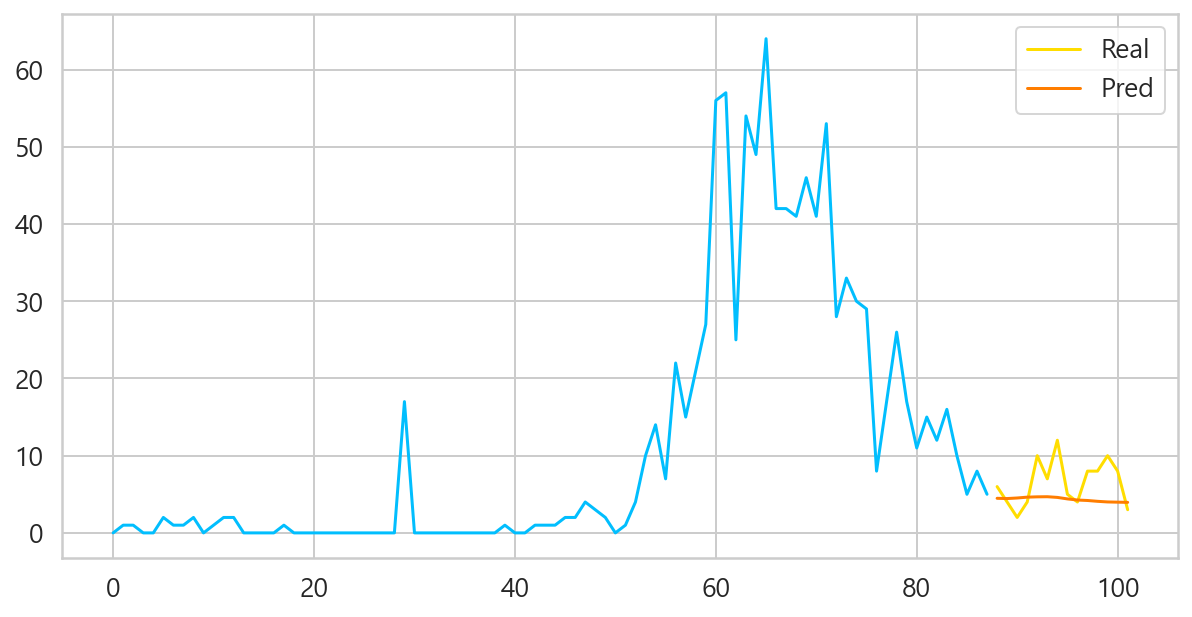

In [52]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [698]:
# 모델 저장
PATH = './models/{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))
torch.save(model, PATH)

In [685]:
# 모델 불러오기
model = torch.load(PATH)

# Use all data for training

In [53]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['target']

In [54]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [55]:
y_all

array([0.      , 0.015625, 0.015625, 0.      , 0.      , 0.03125 ,
       0.015625, 0.015625, 0.03125 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.265625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.015625, 0.      , 0.      ,
       0.015625, 0.015625, 0.015625, 0.03125 , 0.03125 , 0.0625  ,
       0.046875, 0.03125 , 0.      , 0.015625, 0.0625  , 0.15625 ,
       0.21875 , 0.109375, 0.34375 , 0.234375, 0.328125, 0.421875,
       0.875   , 0.890625, 0.390625, 0.84375 , 0.765625, 1.      ,
       0.65625 , 0.65625 , 0.640625, 0.71875 , 0.640625, 0.828125,
       0.4375  , 0.515625, 0.46875 , 0.453125, 0.125   , 0.265625,
       0.40625 , 0.265625, 0.171875, 0.234375, 0.1875  , 0.25    ,
       0.15625 , 0.078125, 0.125   , 0.078125, 0.09375 , 0.062

In [56]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (102, 331)
y_all :  (102,)


In [57]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [58]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

Epoch 0 train loss: 0.10715829581022263


KeyboardInterrupt: 

# Predicting future cases

In [59]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [60]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [61]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

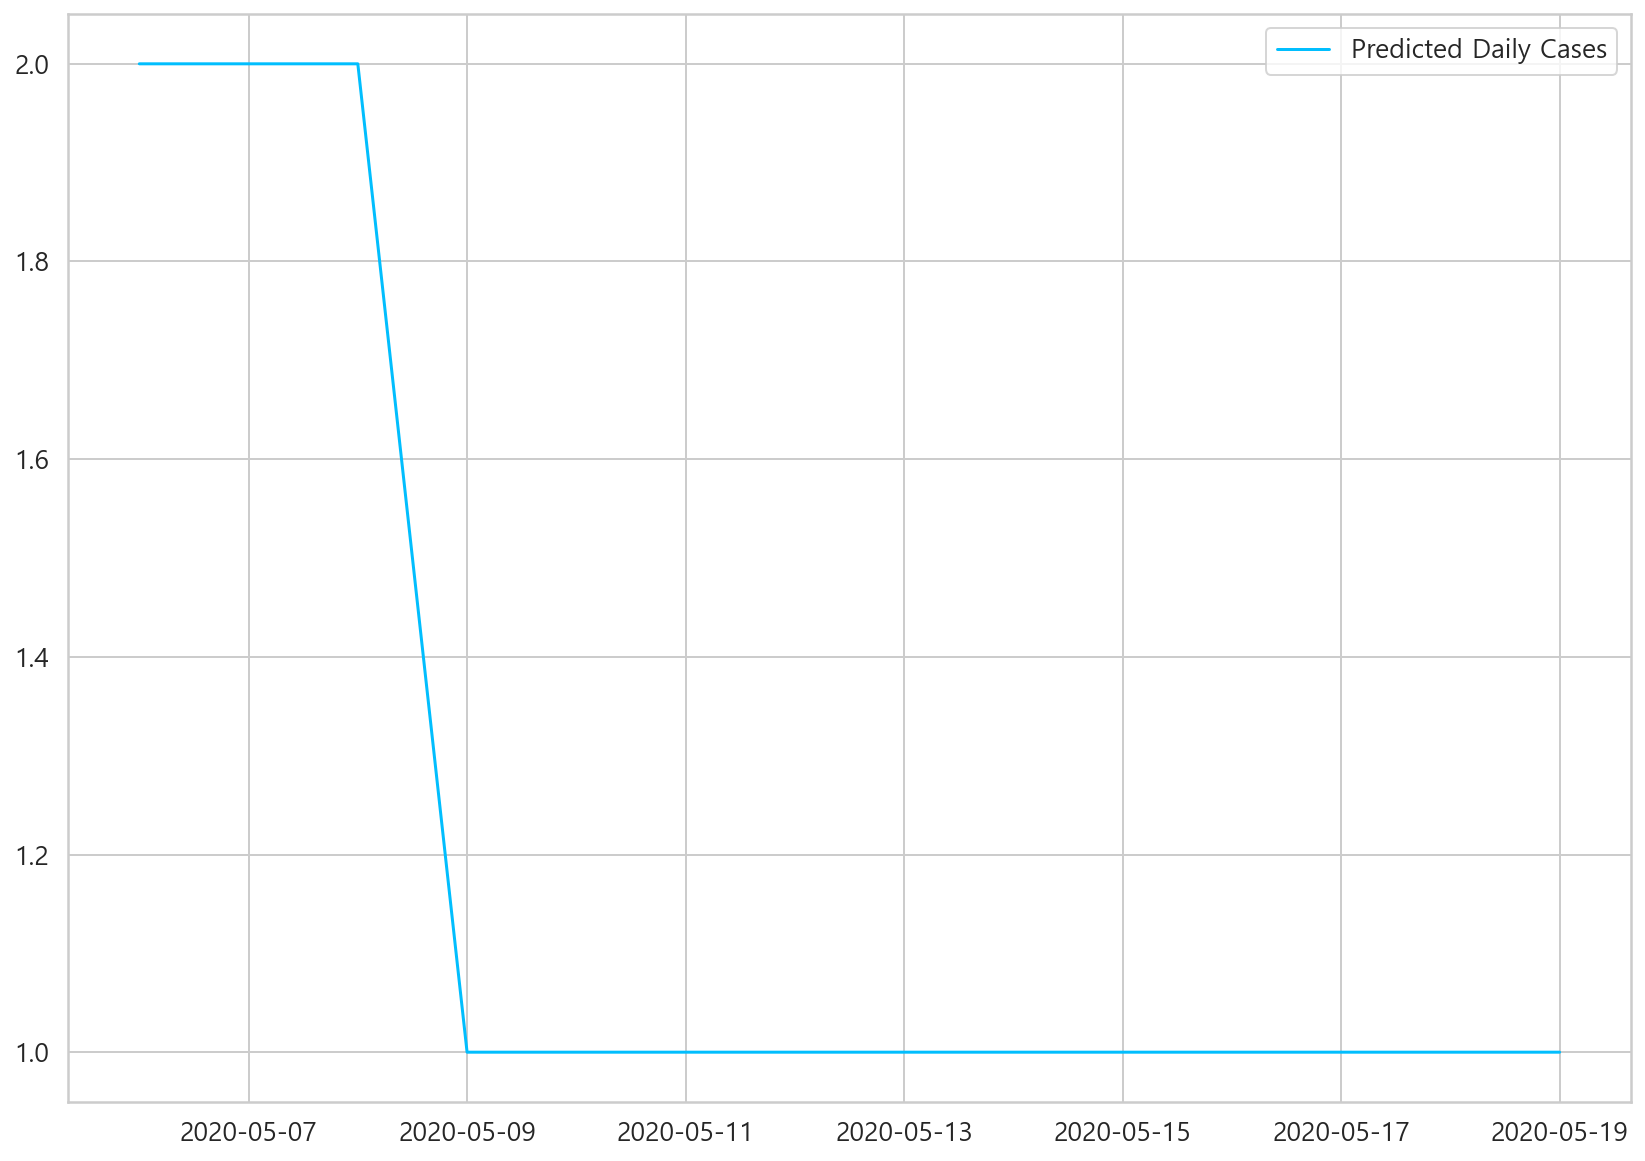

In [62]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [63]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [64]:
preds_

,0
2020-05-06,2
2020-05-07,2
2020-05-08,2
2020-05-09,1
2020-05-10,1
2020-05-11,1
2020-05-12,1
2020-05-13,1
2020-05-14,1
2020-05-15,1


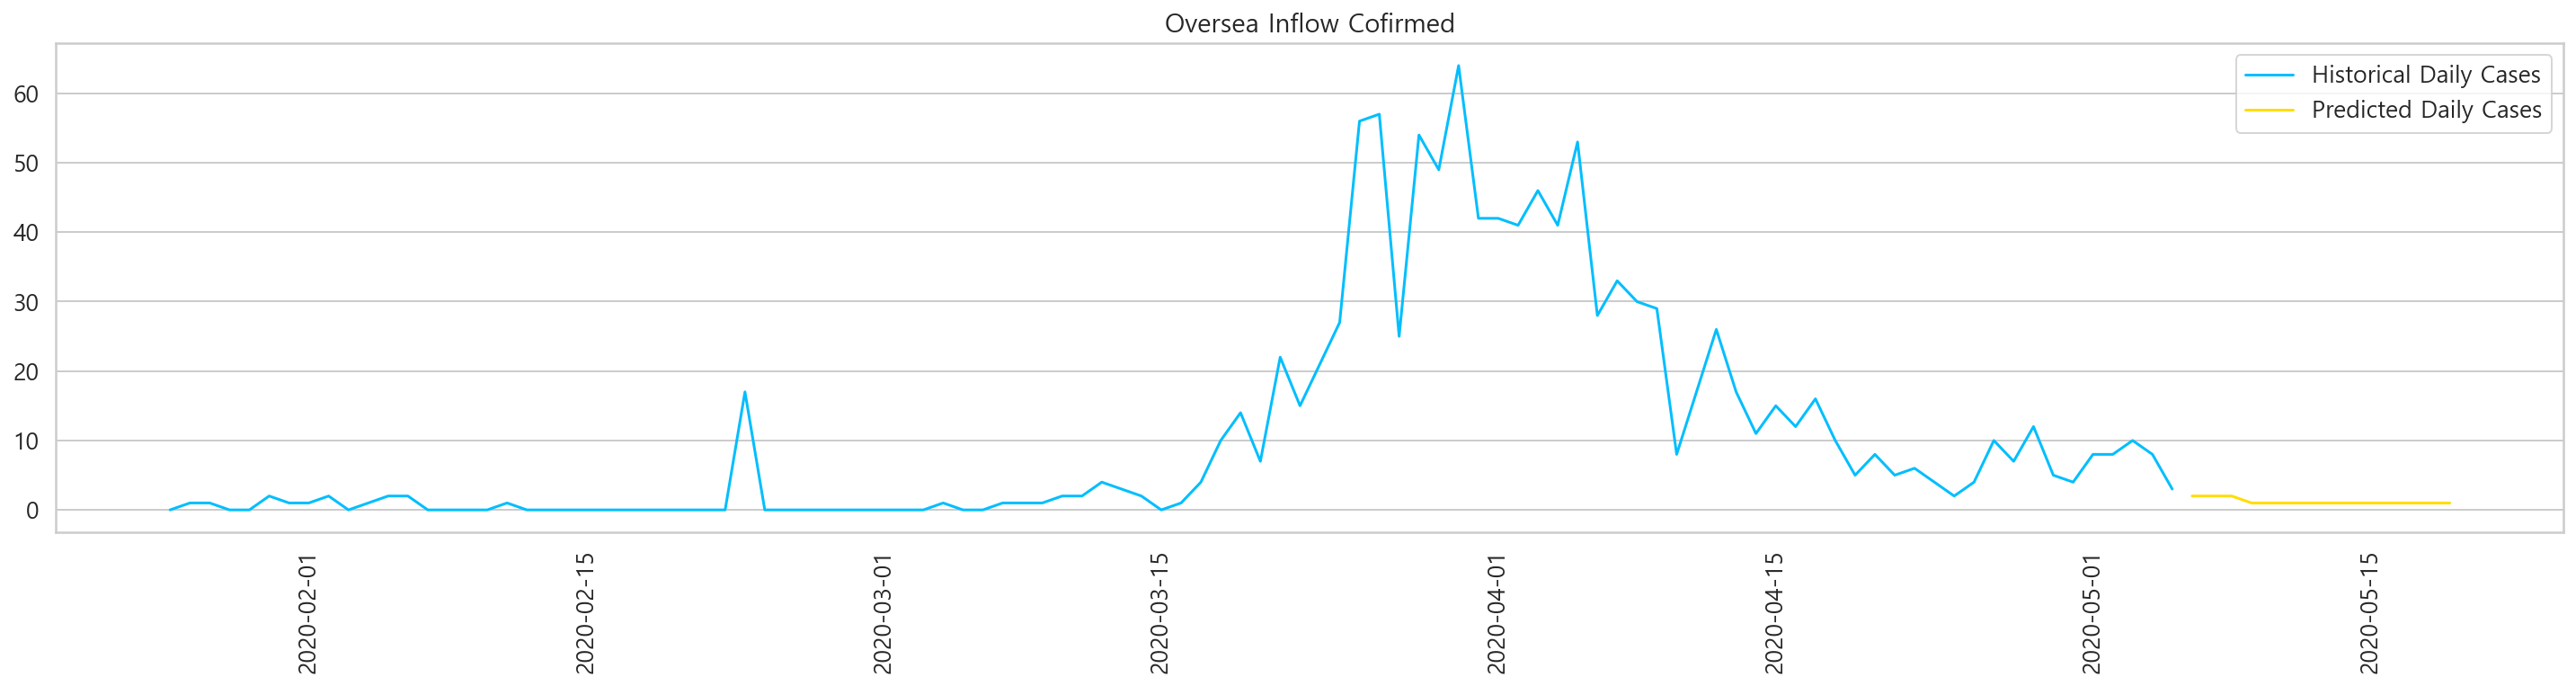

In [65]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();